## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# For cleaning and processing
import json
import os, re
from random import randint
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

# For Modeling and Computing Accuracy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile, f_classif
from scipy.sparse import hstack

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Importing the Data

In [2]:
# These are the file paths from where the dataset will be accesses
METADATA_FILEPATH = Path('C:/train.json')  # To change with your filepath
ARTICLES_FILEPATH = Path('C:/train_articles')  # To change with your filepath

# Read in the metadata file.
with open(METADATA_FILEPATH, 'r') as f:
    claims = json.load(f)

# Inspect the first claim.
claim = claims[0]
print('Claim:', claim['claim'])
print('Speaker:', claim['claimant'])
print('Date:', claim['date'])
print('Related Article Ids:', claim['related_articles'])

# Print the first evidence article.
idx = claim['related_articles'][0]
print('First evidence article id:', idx)
with open(os.path.join(ARTICLES_FILEPATH, '%d.txt' % idx), 'r', encoding="utf8") as f:
    print(f.read())

Claim: A line from George Orwell's novel 1984 predicts the power of smartphones.
Speaker: 
Date: 2017-07-17
Related Article Ids: [122094, 122580, 130685, 134765]
First evidence article id: 122094
1984: George Orwell predicted 2017 almost 70 years ago
April, 1984. 13:00. Comrade 6079, Winston Smith, thinks a thought, starts a diary, and falls in love. But Big Brother is always watching. Set in a world where an invasive government keeps a malevolently watchful eye on its citizens, this radical and much-lauded staging explores surveillance, identity and why Orwell?s vision of the future is as relevant now as ever. Now with a brand new Australian cast, we bring adapter-directors Robert Icke and Duncan Macmillan?s thrilling vision back to Australia for a national tour.

THERE was no crystal ball, no religious apparitions or voices from the dead when George Orwell wrote Nineteen Eighty-Four, accurately depicted our present almost 70 years ago.

It’s no coincidence that Orwell’s 1949 novel ha

Saving the claims.json as pandas dataframe

In [3]:
#Claims as a dataframe
claims_pd=pd.DataFrame(claims)
#Create a copy of claims dataframe
claims = claims_pd.copy(deep = True)
# Let's take a look at the dataset
claims_pd.head()

,claim,claimant,date,id,label,related_articles
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


**The set of numbers in 'related_articles' column denote the respective related articles for a particular claim**

## Data Exploration

In [4]:
#Counting the frequency of unique values in the label column
claims_pd['label'].value_counts()

0    7408
1    6451
2    1696
Name: label, dtype: int64

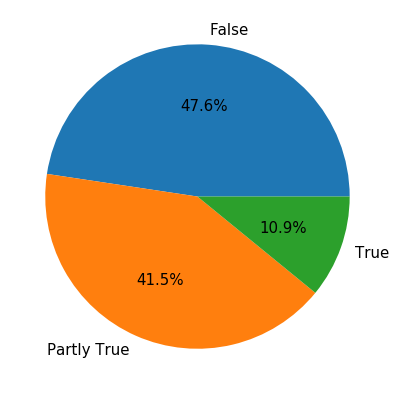

In [5]:
#Plotting a Pie chart for the no. of False, Partly True and True labels
labels = 'False', 'Partly True', 'True'
sizes = [x for x in claims_pd['label'].value_counts()]

plt.figure(figsize=(10,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 15})

plt.show()

**The pie chart represents how varied the portion of false, partly true and true claims in the dataset is. We can observe that there is only 11% of true claims while there is about 48% of false claims**

**Let's explore further**

In [6]:
#Counting the frequency of unique values in the claimant column
claims_pd['claimant'].value_counts()[1:6] #1st entry is omitted because it is null 

Donald Trump       1233
Bloggers            372
Barack Obama        234
Hillary Clinton     220
Viral image         127
Name: claimant, dtype: int64

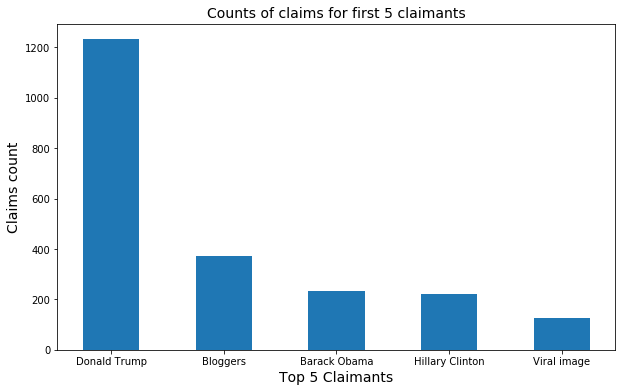

In [7]:
#Plotting a bar graph for count of the claims for the first 5 claimants
plt.figure(figsize=(10,6))
label = ['Donald Trump', 'Bloggers', 'Barack Obama', 'Hillary Clinton', 'Viral image']

data = [claims_pd['claimant'].value_counts()[1:6][i] for i in range(5)] 
plt.bar(label, height = data, width = 0.5)
#Setting the title
plt.title('Counts of claims for first 5 claimants', fontsize=14)
#Setting the x-label
plt.xlabel('Top 5 Claimants',fontsize=14)
#Seting the y-label
plt.ylabel('Claims count',fontsize=14)

plt.show()

**The plot above represents the top 5 counts of claims made by the claimants. Out of them Donald Trump had the highest number of claims made**

**We will divide this further**

In [8]:
#Putting the top five claimants in a list
top5 = claims_pd[(claims_pd['claimant'] == 'Donald Trump') | (claims_pd['claimant'] == 'Bloggers') | (claims_pd['claimant'] == 'Barack Obama') | (claims_pd['claimant'] =='Hillary Clinton') | (claims_pd['claimant'] =='Viral image')]
top5['label_new'] = top5['label'].map({0: 'False', 1:'Partly True', 2: 'True'})

C:\Users\siddh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


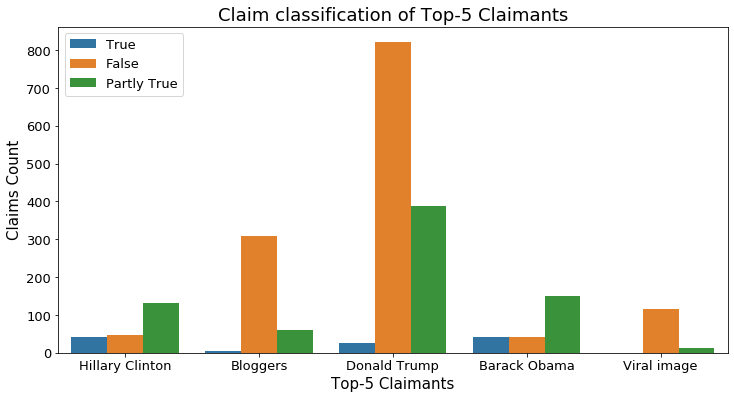

In [9]:
#Plotting a histogram of for the top 5 claimants and the validity of their claim
plt.figure(figsize=(12,6))
sns.countplot(x='claimant',data=top5,hue='label_new')
#Setting the title
plt.title('Claim classification of Top-5 Claimants', fontsize=18)
#Setting the x-label
plt.xlabel('Top-5 Claimants',fontsize=15)
plt.xticks(fontsize=13)
#Setting the y-label
plt.ylabel('Claims Count',fontsize=15)
plt.yticks(fontsize=13)

plt.legend(fontsize=13)

plt.show()

**The above plot represents the distribution of number of false, partly true and true claims made by the top 5 claimants**

**Out of the top 5 only Barack Obama and Hilary Clinton made true claims more than the false or partly true claims**

**Also it is astonishing to note that Donald Trump made more false claims than 50% of the his total claims**

## Data Cleaning

### a) Cleaning Articles

**Extracting the articles from the system and merging the articles for the respective claims below. Then, performing text cleaning on the merged article for each claim, removing stopwords, converting the letters to small case, and stemming the words**

In [10]:
# Defining a new function to concatenate and clean the articles

def new_data(ind):
    concat_article = []
    for i in range(len(claims_pd.iloc[ind, -1])):
        article_number = claims_pd.iloc[ind, -1][i]
        with open(os.path.join(ARTICLES_FILEPATH, '%d.txt' % article_number), 'r', encoding="utf8") as f:
            a = f.read()
        concat_article.append(a)
    new = []
    for a in range(len(concat_article)):
        sp = concat_article[a].split('\n')
        new.append(sp)
    
    sentences = sent_tokenize(str(new))
    tokens = re.split(r'\W+', str(sentences))
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    stemmatizer = SnowballStemmer('english')
    stemmatized = [stemmatizer.stem(word) for word in words]
    return(stemmatized)

In [11]:
#Applying the above function to our dataframe
start = time.time()
clean_articles = [str(new_data(i)) for i in range(len(claims_pd))]
print('Execution time for concatinating and cleaning the articles = ', time.time()-start)

Execution time for concatinating and cleaning the articles =  1299.4717214107513


### b) Cleaning Claims

The process for text cleaning is the same as that of articles.

In [12]:
# Defining a function to clean the claims

def clean_claim(ind):
    
    sentences = sent_tokenize(str(claims_pd.iloc[ind, 0]))
    tokens = re.split(r'\W+',str(sentences))
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    stemmatizer = SnowballStemmer('english')
    stemmatized = [stemmatizer.stem(word) for word in words]
    return(stemmatized)

In [13]:
#Applying the above function to our dataframe
clean_claims = [str(clean_claim(i)) for i in range(len(claims_pd))]

### c) Appending cleaned articles and claims in the claims_pd dataframe.

In [14]:
#Adding our cleaned claims and cleaned articles to the orignal dataframe
claims_pd['clean articles'] = clean_articles
claims_pd['clean claims'] = clean_claims

claims_pd.head()

,claim,claimant,date,id,label,related_articles,clean articles,clean claims
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","['georg', 'orwel', 'predict', 'almost', 'year'...","['line', 'georg', 'orwel', 'novel', 'predict',..."
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]","['republican', 'critic', 'parkland', 'student'...","['main', 'legislatur', 'candid', 'lesli', 'gib..."
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]","['first', 'person', 'complet', 'nasa', 'passpo...","['year', 'old', 'girl', 'name', 'alyssa', 'car..."
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]","['danger', 'measl', 'tweet', 'march', 'mani', ...","['author', 'roald', 'dahl', 'pen', 'open', 'le..."
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]","['remark', 'counterterror', 'stanford', 'unive...","['come', 'fight', 'terror', 'anoth', 'thing', ..."


**A column is added with the Year of the claim below**

In [15]:
#Adding a new column showing the year for the made claim
claims_pd['year'] = [int(claims_pd['date'][i][0:4]) for i in claims_pd.index]
#Adding a new column showing the validity(label) for the made claim
claims_pd['label_new'] = claims_pd['label'].map({0: 'False', 1:'Partly True', 2: 'True'})

claims_pd.head()

,claim,claimant,date,id,label,related_articles,clean articles,clean claims,year,label_new
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","['georg', 'orwel', 'predict', 'almost', 'year'...","['line', 'georg', 'orwel', 'novel', 'predict',...",2017,False
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]","['republican', 'critic', 'parkland', 'student'...","['main', 'legislatur', 'candid', 'lesli', 'gib...",2018,True
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]","['first', 'person', 'complet', 'nasa', 'passpo...","['year', 'old', 'girl', 'name', 'alyssa', 'car...",2018,Partly True
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]","['danger', 'measl', 'tweet', 'march', 'mani', ...","['author', 'roald', 'dahl', 'pen', 'open', 'le...",2019,True
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]","['remark', 'counterterror', 'stanford', 'unive...","['come', 'fight', 'terror', 'anoth', 'thing', ...",2016,True


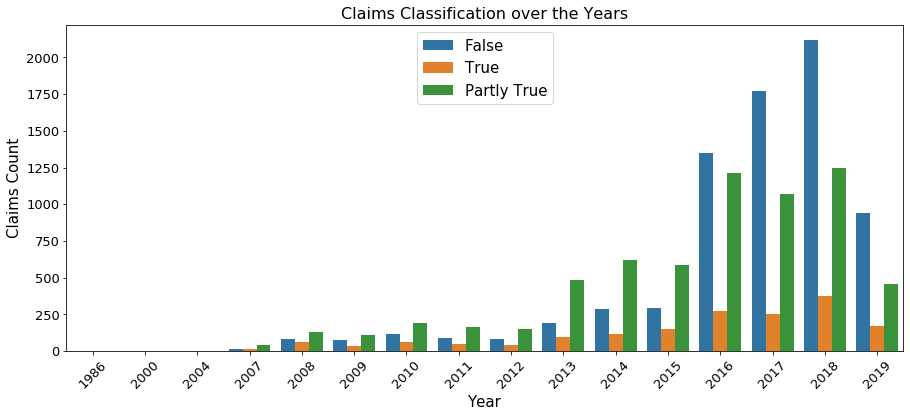

In [16]:
#Plotting a histogram for the no of claims over the years and their label
plt.figure(figsize=(15,6))
sns.countplot(x='year',data=claims_pd,hue='label_new')
#Setting the title
plt.title('Claims Classification over the Years', fontsize=16)
#Setting the x-label
plt.xlabel('Year',fontsize=15)
plt.xticks(fontsize=13, rotation = 45)
#Setting the y-label
plt.ylabel('Claims Count',fontsize=15)
plt.yticks(fontsize=13)

plt.legend(fontsize=15)

plt.show()

The plot depicts the bifurcation of claims made each year. As we can see the number of claims made kept on increasing until 2018 and along with it the count of false claims also kept on increasing each year.

**Note: As there isn't much data for 2019 in our dataset, a low count is observed which should not be confused with low count of claims made actually in that year**

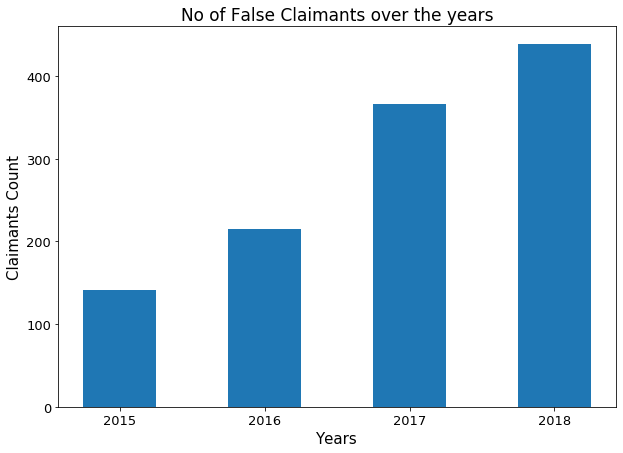

In [17]:
#Plotting a bar chart for the no. of false claimants over the years
fc = claims_pd[claims_pd['label']==0].groupby(['year'])['claimant'].nunique()[9:13]
label = ['2015', '2016', '2017', '2018']
plt.figure(figsize=(10,7))
plt.bar(label, height = fc, width = 0.5)

#Setting the title
plt.title('No of False Claimants over the years', fontsize=17)
#Setting the x-label
plt.xlabel('Years',fontsize=15)
plt.xticks(fontsize=13)
#Seting the y-label
plt.ylabel('Claimants Count',fontsize=15)
plt.yticks(fontsize=13)

plt.show()

The bar-chart shows how the number of false claimants have increased year-on-year since 2015 to 2018

**For the model, we will omit the claims made by Donald Trump, Hillary Clinton and Barack Obama and then make predictions on these omitted datapoints**

**Splitting the dataset below**

In [18]:
big = claims_pd[~ ((claims_pd['claimant']=='Donald Trump') | (claims_pd['claimant']=='Hillary Clinton') | (claims_pd['claimant']=='Barack Obama'))] 
# Training data set without taking Donald Trump, Hillary Clinton and Barack Obama in the data set

small = claims_pd[(claims_pd['claimant']=='Donald Trump') | (claims_pd['claimant']=='Hillary Clinton') | (claims_pd['claimant']=='Barack Obama')] 
# Testing data set with Donald Trump, Hillary Clinton and Barack Obama in the data set

In [19]:
big.head()  #Displaying the training dataset

,claim,claimant,date,id,label,related_articles,clean articles,clean claims,year,label_new
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","['georg', 'orwel', 'predict', 'almost', 'year'...","['line', 'georg', 'orwel', 'novel', 'predict',...",2017,False
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]","['republican', 'critic', 'parkland', 'student'...","['main', 'legislatur', 'candid', 'lesli', 'gib...",2018,True
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]","['first', 'person', 'complet', 'nasa', 'passpo...","['year', 'old', 'girl', 'name', 'alyssa', 'car...",2018,Partly True
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]","['danger', 'measl', 'tweet', 'march', 'mani', ...","['author', 'roald', 'dahl', 'pen', 'open', 'le...",2019,True
5,"Rhode Island is ""almost dead last"" among North...",Leonidas Raptakis,2014-02-11,7,2,"[8284, 3768, 20091, 82368, 73148, 4493]","['lis', 'code', 'virginia', 'prev', 'next', 'p...","['rhode', 'island', 'almost', 'dead', 'last', ...",2014,True


## Model Preparation

**As the datasets are ready now, dataset is vecorized using TF-IDF and the model implementation is done**

Using TF-IDF vectorizer for converting the text to vectors.

Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

Source - https://en.wikipedia.org/wiki/Tf%E2%80%93idf

### a) Vectorizing training dataset

In [20]:
#Using the Tfidf Vectorizer on the training set

vectorizer1 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2', max_features = 1400)
vectorizer1.fit(big['clean claims']+big['clean articles'])
array_TFIDF1 = vectorizer1.transform(big['clean claims']+big['clean articles'])

### b) Vectorizing testing dataset

In [21]:
#Vectorizing the test set

array_TFIDF2 = vectorizer1.transform(small['clean claims']+small['clean articles'])

In [22]:
#Allocating the training and testing datasets

X_train = array_TFIDF1
X_test = array_TFIDF2
y_train = big['label']
y_test = small['label']

## Model Implementation

**Let's implement algorithms on the training dataset**

**a) Random Forest**

In [23]:
#Using the Random Forest Algorithm
rf = RandomForestClassifier(random_state = 0)
#Fitting the model
rf.fit(X_train, y_train)
predictions0 = rf.predict(X_test)
#Finding the accuracy of the predictions
ACCU = accuracy_score(y_test, predictions0)
print('Accuracy:', ACCU)
#Printing the classification report 
print(classification_report(y_test,predictions0))

C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.5447540011855364
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       910
           1       0.48      0.55      0.51       669
           2       0.11      0.03      0.04       108

    accuracy                           0.54      1687
   macro avg       0.40      0.39      0.39      1687
weighted avg       0.53      0.54      0.53      1687



**b) XGBoost**

In [24]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
ACCU = accuracy_score(y_test, predictions)
print('Accuracy:', round(ACCU,2))
print(classification_report(y_test,predictions))

C:\Users\siddh\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:50:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       910
           1       0.52      0.66      0.58       669
           2       0.10      0.01      0.02       108

    accuracy                           0.61      1687
   macro avg       0.44      0.44      0.42      1687
weighted avg       0.59      0.61      0.59      1687



**c) Support Vector Machines (SVM)**

In [25]:
#Using SVM ( Linear ) model
svcl = LinearSVC(random_state = 0)
#Fitting the model
svcl.fit(X_train, y_train)
predictions2 = svcl.predict(X_test)
#Finding the accuracy of the predictions
ACCU = accuracy_score(y_test, predictions2)
print('Accuracy:', ACCU)
#Printing the classification report 
print(classification_report(y_test,predictions2))

Accuracy: 0.5263781861292235
              precision    recall  f1-score   support

           0       0.63      0.49      0.55       910
           1       0.45      0.65      0.53       669
           2       0.38      0.05      0.08       108

    accuracy                           0.53      1687
   macro avg       0.49      0.40      0.39      1687
weighted avg       0.54      0.53      0.51      1687



**d) Logistic Regression**

In [26]:
#Using Logistic Regression
model_LR = LogisticRegression()
model_LR.fit(X_train,y_train)
predictions3 = model_LR.predict(X_test)
#Finding the accuracy of the predictions
ACCUs = accuracy_score(y_test, predictions3)
print('Accuracy:', ACCUs)
#Printing the classification report 
print(classification_report(y_test,predictions3))

C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.5370480142264374
              precision    recall  f1-score   support

           0       0.64      0.51      0.57       910
           1       0.46      0.66      0.54       669
           2       0.33      0.01      0.02       108

    accuracy                           0.54      1687
   macro avg       0.48      0.39      0.38      1687
weighted avg       0.55      0.54      0.52      1687



**Out of the models implemented, XGBoost performs best as it gave the best combination of accuracy and macro F1 score. Therefore, selecting this model for further analysis**

## Discussions on model

**Plotting to make inferences from our model and discuss the viability**

In [27]:
#Converting our y_test list to a dataframe
x = pd.DataFrame(y_test)

#Defining new columns
x['predictions'] = predictions
x['Year'] = small['year']
x['claimant'] = small['claimant']
x['label_new'] = x['label'].map({0: 'False', 1:'Partly True', 2: 'True'})
x['Prediction Class']=['Correct' if x['label'][i]==x['predictions'][i] else 'Incorrect' for i in x.index]

#Counting the no. of Correct and Incorrect predictions
x['Prediction Class'].value_counts()

Correct      1023
Incorrect     664
Name: Prediction Class, dtype: int64

**a) Plotting to see how good our model worked**

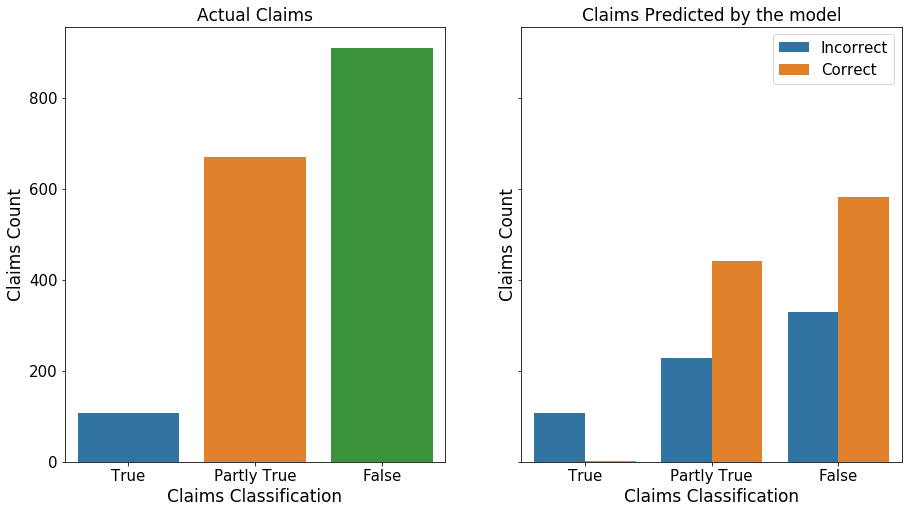

In [28]:
#Plotting a bar graph for the validity(label) of the actual claims
fig, p=plt.subplots(nrows=1, ncols=2, figsize=(15,8), sharey = True)
sns.countplot(x='label_new',data=x,ax=p[0])
#Setting the title
p[0].set_title('Actual Claims', fontsize = 17)
#Setting the x-label
p[0].set_xlabel('Claims Classification', fontsize = 17)
#Setting the y-label
p[0].set_ylabel('Claims Count', fontsize = 17)
p[0].tick_params(axis='both', which='major', labelsize=15)

#Plotting a bargraph for the predicted claims and their accuracy
sns.countplot(x='label_new',data=x,hue='Prediction Class',ax=p[1])
#Setting the title
p[1].set_title('Claims Predicted by the model', fontsize = 17)
#Setting the x-label
p[1].set_xlabel('Claims Classification', fontsize = 17)
#Setting the y-label
p[1].set_ylabel('Claims Count', fontsize = 17)
p[1].tick_params(axis='both', which='major', labelsize=15)
p[1].legend(fontsize=15)

plt.show()

**From the plot it can be inferred that the model correctly predicted the false claims better than the others as the data for false claims is more as compared to that of the true or partly true claims**

**And with more/equivalent number of datapoints for the other two categories, our model can predict classes more accurately**

**b) Plotting for count of claims distributed over the years**

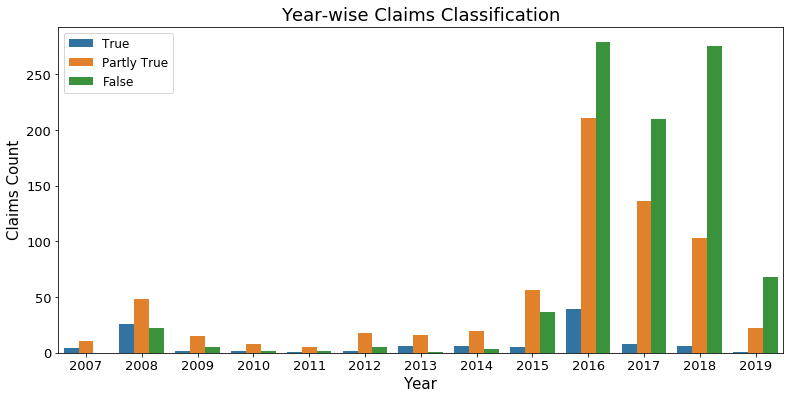

In [29]:
plt.figure(figsize=(13,6))
#Plotting a graph for no of claims made by Donald Trump over the years and their validity(label)
sns.countplot(x='Year',data=x,hue='label_new')
#Setting the title
plt.title('Year-wise Claims Classification', fontsize=18)
plt.legend(loc = 2, fontsize=12)
#Setting the x-label
plt.xlabel('Year',fontsize=15)
plt.xticks(fontsize=13)
#Setting the y-label
plt.ylabel('Claims Count',fontsize=15)
plt.yticks(fontsize=13)
#Displaying the graph
plt.show()

**The plot shows the collective number of false, partly true, true claims made by Donald Trump, Hillary Clinton and Barack Obama each year. It can be inferred that collectively they made mostly false claims and the peak was around the time of USA 2016 elections**

**Let's explore further on the Correct Predictions of our testing dataset**

**a) Plotting distribution of claims for the three politicians**

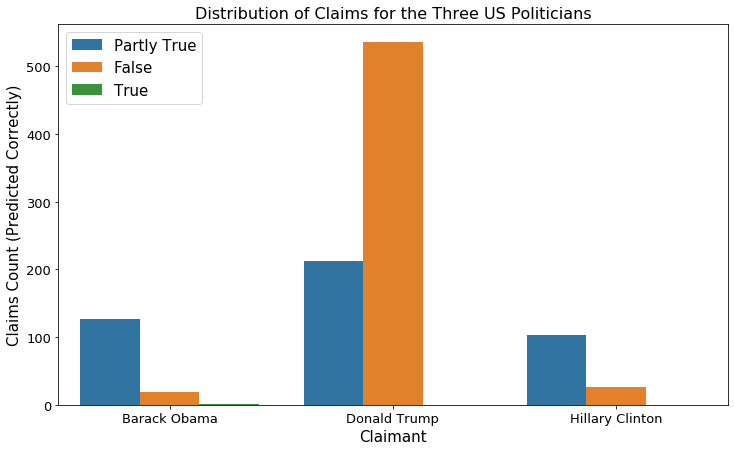

In [30]:
plt.figure(figsize=(12,7))
ax = sns.countplot(x="claimant", data=x[x['Prediction Class']=='Correct'], hue='label_new')
plt.xlabel('Claimant',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Claims Count (Predicted Correctly)',fontsize=15)
plt.yticks(fontsize=13)
plt.title("Distribution of Claims for the Three US Politicians", fontsize=16)
plt.legend(fontsize=15)
plt.show()

**The model has correctly predicted the above count of claims made by the politicians**

**It can be observed that the highest count is of false claims made by Donald Trump**

**b) Plotting distribution of false claims made by Donald Trump over the years**

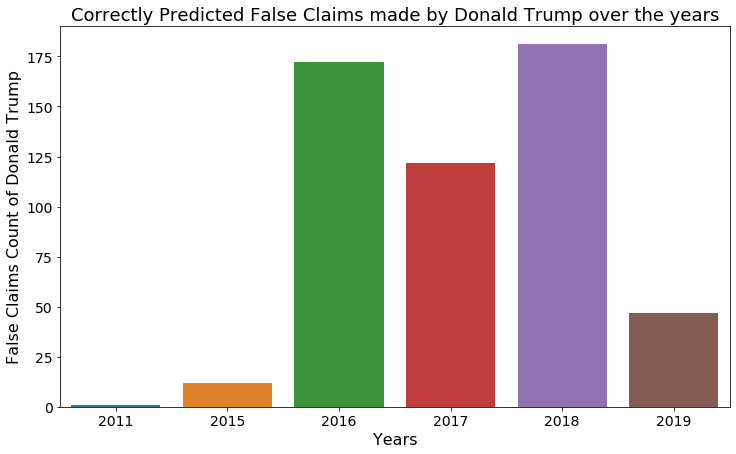

In [31]:
plt.figure(figsize=(12,7))
ax = sns.countplot(x="Year", data=x[(x['Prediction Class']=='Correct') & (x['claimant']=='Donald Trump') & (x['label_new']=='False')])
plt.xlabel('Years',fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('False Claims Count of Donald Trump',fontsize=16)
plt.yticks(fontsize=14)
plt.title("Correctly Predicted False Claims made by Donald Trump over the years", fontsize=18)
plt.show()

**It can be inferred that the count of false claims by Donald Trump increased exponentially until 2016 after which he came to power. Even after coming to power, he carried out the same philosophy and kept on making false claims**

**This shows that since his ideology of making false claims worked for the better for him during the elections, he didn't stop it and relied on the same to influence the American society**

**Here are some of the examples of false claims made by Donald Trump after he became President. These claims were correctly predicted by the model as false**

In [32]:
print ("The claim made - ",claims_pd.loc[3445].claim, "\n\nDetails of the claim -\n",x.loc[3445])

The claim made -   “In fact the GDP since I’ve taken over has doubled and tripled.”  

Details of the claim -
 label                          0
predictions                    0
Year                        2018
claimant            Donald Trump
label_new                  False
Prediction Class         Correct
Name: 3445, dtype: object


#### This is a wild exaggeration. U.S. gross domestic product grew by 2.3 per cent in 2017. It grew by 2 per cent in the first quarter of 2018.

Source: https://projects.thestar.com/donald-trump-fact-check/

In [33]:
print ("The claim made - ",claims_pd.loc[7825].claim, "\n\nDetails of the claim -\n", x.loc[7825])

The claim made -   "I don’t know if you noticed, but deficits seem to be coming down."  

Details of the claim -
 label                          0
predictions                    1
Year                        2019
claimant            Donald Trump
label_new                  False
Prediction Class       Incorrect
Name: 7825, dtype: object


#### In fact, the deficit in the first three months of fiscal year 2019 was 42 percent higher than it was for the same period last year.

Source: https://www.factcheck.org/2019/02/trump-disinformation-on-deficits/

**c) Plotting confusion matrix heatmap of our model**

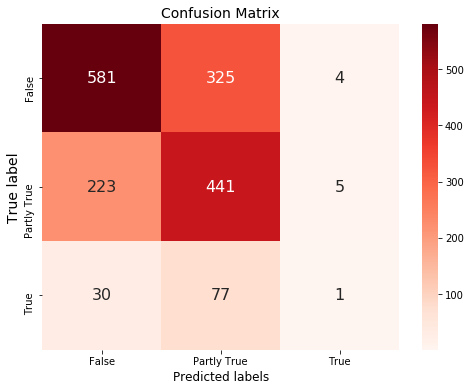

In [34]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
#Plotting a confusion matrix for the Actual vs Predicted labels
plt.figure(figsize=(8,6))
labels = ['False', 'Partly True', 'True']
cm = confusion_matrix(y_test, predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g',cmap='Reds') #annot=True to annotate cells
#Setting the x-label
ax.set_xlabel('Predicted labels',fontsize=12)
#Setting the y-label
ax.set_ylabel('True label',fontsize=14)
#Setting the title
ax.set_title('Confusion Matrix',fontsize=14) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
#Displaying the matrix
plt.show()

**From the confusion matrix heatmap, we can determine that our model works quite good for False claims. This emphasizes the need of more datapoints for the other two categories to build a model upon**

## Cosine Similarity Implementation with text summarization

The part for concatinating and cleaning of the articles is taking a lot of time as we are directly performing the text preprocessing on the full article, to speed up the process we can just take the top 5 sentences having the highest cosine similarity with the claim. After we get the top 5 sentences then we preprocess those to get the clean article column. Part for cleaning the claims is same as before. Articles, claims and claimants are vectorized together and then split for model implementation. But here I will only show XGBoost model as it performed the best among all the models implemented.

In [35]:
# Defining a new function to concatenate and select top 5 important sentences in the articles

def imp_data(ind):
    concat_article = []
    important_sentences = []
    for i in range(len(claims.iloc[ind, -1])):
        article_number = claims.iloc[ind, -1][i]
        with open(os.path.join(ARTICLES_FILEPATH, '%d.txt' % article_number), 'r', encoding="utf8") as f:
            a = f.read()
        concat_article.append(a)
    new = []
    for a in range(len(concat_article)):
        sp = concat_article[a].split('\n')
        new.append(sp)

    sentences = sent_tokenize(str(new))

    # append claim to articles
    sentences.append(claims.iloc[ind, 0])

    # vectorize sentences based on tf-idf
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    # measure similarity between claim and each sentence
    if X.shape[0] == 2:
        similarity = cosine_similarity(X[1], X[0]) 
    else:
        similarity = cosine_similarity(X[-1], X[:-2])

    # find top 5 sentences with greatest similarity
    sorted_index = np.argsort(similarity)[0][::-1]
    top_sentences = []
    for i in range(0,min(5, len(sorted_index))):
        top_sentences.append(sentences[sorted_index[i]])
    important_sentences.append(top_sentences)
    return(important_sentences)

In [36]:
#Applying the above function to our dataframe
start = time.time()
important_sentences = [str(imp_data(i)) for i in range(len(claims_pd))]
print('Execution time for concatinating and summarizing the articles = ', time.time()-start)

Execution time for concatinating and summarizing the articles =  555.5045866966248


In [37]:
# Defining a function to clean the articles

def clean_data(new):
    sentences = sent_tokenize(str(new))
    tokens = re.split(r'\W+', str(sentences))
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    stemmatizer = SnowballStemmer('english')
    stemmatized = [stemmatizer.stem(word) for word in words]
    return(stemmatized)

In [38]:
#Applying the above function to our important sentences
start = time.time()
clean_articles = [str(clean_data(important_sentences[i])) for i in range(len(claims_pd))]
print('Execution time for cleaning the articles = ', time.time()-start)

Execution time for cleaning the articles =  32.257538080215454


In [39]:
#Adding our cleaned claims and cleaned articles to the orignal dataframe
claims['clean articles'] = clean_articles
claims['clean claims'] = clean_claims

claims.head()

,claim,claimant,date,id,label,related_articles,clean articles,clean claims
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","['georg', 'orwel', 'dystopian', 'novel', 'engl...","['line', 'georg', 'orwel', 'novel', 'predict',..."
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]","['email', 'protect', 'photo', 'robert', 'f', '...","['main', 'legislatur', 'candid', 'lesli', 'gib..."
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]","['first', 'person', 'complet', 'nasa', 'passpo...","['year', 'old', 'girl', 'name', 'alyssa', 'car..."
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]","['twenti', 'year', 'later', 'roald', 'dahl', '...","['author', 'roald', 'dahl', 'pen', 'open', 'le..."
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]","['anoth', 'thing', 'know', 'work', 'base', 'lo...","['come', 'fight', 'terror', 'anoth', 'thing', ..."


### Vectorizing claims, articles, claimants

In [40]:
#Using the Tfidf Vectorizer on the claims, articles, claimants

vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2')
X1 = vectorizer.fit_transform(claims['clean claims'])
X2 = vectorizer.fit_transform(claims['clean articles'])
X3 = vectorizer.fit_transform(claims['claimant'])

In [41]:
y = claims_pd['label']
X = train3 =hstack((X1, X2, X3))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3, stratify = y)

### Model Implementation

#### XGBoost

In [42]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
ACCU = accuracy_score(y_test, predictions)
print('Accuracy:', ACCU)
print(classification_report(y_test,predictions))

C:\Users\siddh\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.6228840797085923
              precision    recall  f1-score   support

           0       0.65      0.72      0.69      2223
           1       0.60      0.67      0.63      1935
           2       0.25      0.02      0.03       509

    accuracy                           0.62      4667
   macro avg       0.50      0.47      0.45      4667
weighted avg       0.58      0.62      0.59      4667

